In [ ]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.4.1
The following GPU devices are available: 


In [ ]:
# you can switch the commented lines here to pick the other model

# ssd mobilenet version 2
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

# You can choose inception resnet version 2 instead
#module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

In [ ]:
#Download and access the pre-trained model

In [ ]:
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def display_image(image):
    """
    Displays an image inside the notebook.
    This is used by download_and_resize_image()
    """
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

In [ ]:
def download_and_resize_image(url, new_width=256, new_height=256):
    '''
    Fetches an image online, resizes it and saves it locally.
    
    Args:
        url (string) -- link to the image
        new_width (int) -- size in pixels used for resizing the width of the image
        new_height (int) -- size in pixels used for resizing the length of the image
        
    Returns:
        (string) -- path to the saved image
    '''
    
    
    # create a temporary file ending with ".jpg"
    _, filename = tempfile.mkstemp(suffix=".jpg")
    
    # opens the given URL
    response = urlopen(url)
    
    # reads the image fetched from the URL
    image_data = response.read()
    
    # puts the image data in memory buffer
    image_data = BytesIO(image_data)
    
    # opens the image
    pil_image = Image.open(image_data)
    
    # resizes the image. will crop if aspect ratio is different.
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)#ANTIALIAS is high-quality filter based on convolutions
    
    # converts to the RGB colorspace
    pil_image_rgb = pil_image.convert("RGB")
    
    # saves the image to the temporary file created earlier
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    
    print("Image downloaded to %s." % filename)
    
    return filename

In [ ]:
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
from PIL import Image
from PIL import ImageOps

In [ ]:
# You can choose a different URL that points to an image of your choice
image_url = "https://upload.wikimedia.org/wikipedia/commons/f/fb/20130807_dublin014.JPG"

# download the image and use the original height and width
downloaded_image_path = download_and_resize_image(image_url, 3872, 2592)

Image downloaded to /tmp/tmpd1xugv4m.jpg.


In [ ]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

    """
    Adds a bounding box to an image.
    
    Args:
        image -- the image object
        ymin -- bounding box coordinate
        xmin -- bounding box coordinate
        ymax -- bounding box coordinate
        xmax -- bounding box coordinate
        color -- color for the bounding box edges
        font -- font for class label
        thickness -- edge thickness of the bounding box
        display_str_list -- class labels for each object detected
    
    
    Returns:
        No return.  The function modifies the `image` argument 
                    that gets passed into this function
    
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    
    # scale the bounding box coordinates to the height and width of the image
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    
    # define the four edges of the detection box
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """
    Overlay labeled boxes on an image with formatted scores and label names.
    
    Args:
        image -- the image as a numpy array
        boxes -- list of detection boxes
        class_names -- list of classes for each detected object
        scores -- numbers showing the model's confidence in detecting that object
        max_boxes -- maximum detection boxes to overlay on the image (default is 10)
        min_score -- minimum score required to display a bounding box
    
    Returns:
        image -- the image after detection boxes and classes are overlaid on the original image.
    """
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        
        # only display detection boxes that have the minimum score or higher
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

            # draw one bounding box and overlay the class labels onto the image
            draw_bounding_box_on_image(image_pil,
                                       ymin,
                                       xmin,
                                       ymax,
                                       xmax,
                                       color,
                                       font,
                                       display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
        
    return image

In [ ]:
def load_img(path):
    '''
    Loads a JPEG image and converts it to a tensor.
    
    Args:
        path (string) -- path to a locally saved JPEG image
    
    Returns:
        (tensor) -- an image tensor
    '''
    
    # read the file
    img = tf.io.read_file(path) #convert to tensor
    
    # convert to a tensor
    img = tf.image.decode_jpeg(img, channels=3) #Decode a JPEG-encoded image to a uint8 tensor.
    
    return img

In [ ]:
def run_detector(detector, path):
    '''
    Runs inference on a local file using an object detection model.
    
    Args:
        detector (model) -- an object detection model loaded from TF Hub
        path (string) -- path to an image saved locally
    '''
    
    # load an image tensor from a local file path
    img = load_img(path)

    # add a batch dimension in front of the tensor
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...] #Convert image to dtype, scaling its values if needed.
                    # ^^ Also, expand dimension to 4D, because model is designed to take in batches of images.Aadditional dimension for the tensor is to store multiple images. Ex:(10,200,200,3) for 10 images of dim(200,200,3)
    
    # run inference using the model
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    # save the results in a dictionary
    result = {key:value.numpy() for key,value in result.items()}

    # print results
    print("Found %d objects." % len(result["detection_scores"]))

    print(result["detection_scores"])
    print(result["detection_class_entities"])
    print(result["detection_boxes"])
    
    # draw predicted boxes over the image
    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

    # display the image
    display_image(image_with_boxes)

Found 100 objects.
[0.43670595 0.34758776 0.2438663  0.23315561 0.22782972 0.21416378
 0.2057755  0.20488328 0.20278934 0.19843656 0.18925622 0.18167153
 0.18141812 0.18016168 0.17810741 0.17738229 0.17522189 0.17424864
 0.17037821 0.1695776  0.16904226 0.16812503 0.1645604  0.16272038
 0.16027087 0.1601066  0.1600163  0.15941423 0.15788302 0.15729004
 0.15717909 0.15715125 0.153166   0.15213975 0.15061927 0.1487934
 0.14763573 0.14687386 0.1466805  0.14592579 0.14561158 0.14550841
 0.14460713 0.14443639 0.14373192 0.14367628 0.1433467  0.14312649
 0.14064187 0.13832903 0.1380971  0.13792625 0.13692603 0.13685742
 0.13657337 0.13628238 0.13564992 0.13426578 0.1296387  0.12808129
 0.12806705 0.12731841 0.12692004 0.12569696 0.12567621 0.1235756
 0.12295878 0.12230799 0.12227914 0.12212852 0.12166294 0.12107769
 0.12079674 0.12078452 0.11986968 0.11960495 0.11948714 0.11928916
 0.11915737 0.11888617 0.11657816 0.11642405 0.11626723 0.11614516
 0.1154097  0.11502749 0.11449328 0.11423436 

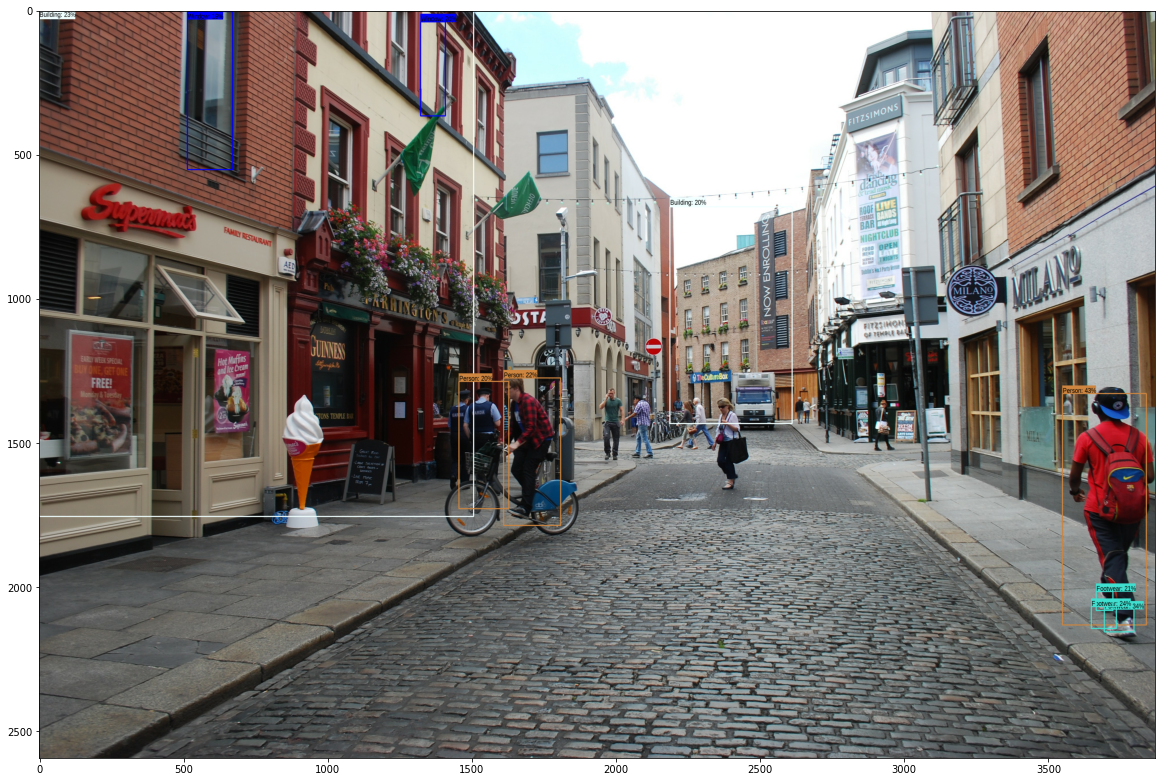

In [ ]:
# runs the object detection model and prints information about the objects found
run_detector(detector, downloaded_image_path) #outputs = Probability, Class, BB corners as numbers, then as image

In [ ]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, 640, 480)
    run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)

Image downloaded to /tmp/tmpc8p0scgl.jpg.
Found 100 objects.
[0.30882788 0.20544642 0.19057229 0.13318923 0.1301761  0.11788762
 0.11146352 0.0995014  0.09708747 0.08934605 0.0858188  0.08409104
 0.08374736 0.0812895  0.08090445 0.07967713 0.07665145 0.07351854
 0.06787938 0.06763101 0.06711239 0.06647995 0.06524611 0.06407446
 0.06344065 0.0633702  0.06195152 0.06105059 0.06085336 0.06070369
 0.06016657 0.05848241 0.05768561 0.05741984 0.05730081 0.0568426
 0.05608243 0.055823   0.05571836 0.05448857 0.05446708 0.05443513
 0.05435091 0.05417293 0.05415317 0.05264324 0.0516898  0.05060172
 0.05004033 0.0496543  0.04951805 0.04944333 0.04944021 0.0493097
 0.04898798 0.04897326 0.04827735 0.04799327 0.04759651 0.04752761
 0.04606029 0.04595798 0.04588816 0.04564145 0.04560605 0.04542083
 0.0454191  0.04503348 0.04479927 0.04464462 0.04455972 0.04444042
 0.04443148 0.044294   0.04353625 0.04304457 0.04298371 0.04291531
 0.04169193 0.04162043 0.0416154  0.04138917 0.04138747 0.04138324
 0.

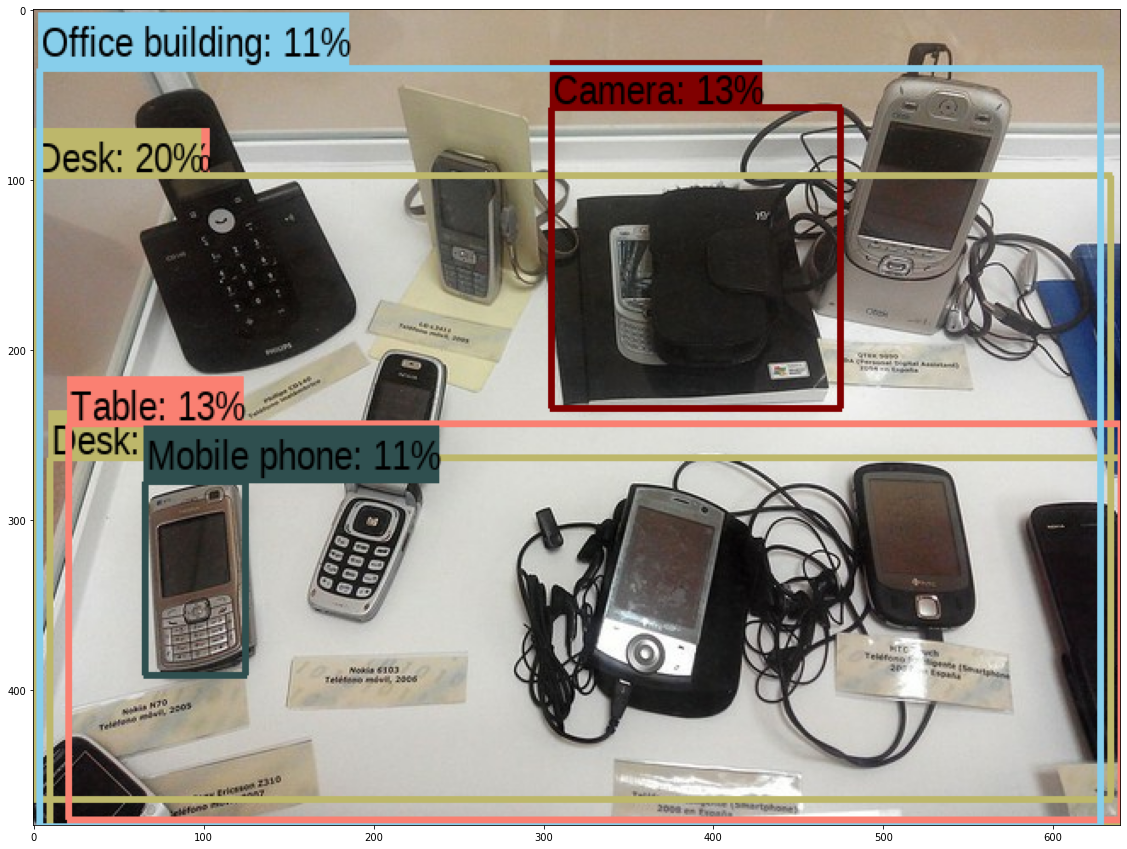

In [ ]:
detect_img(image_urls[1])